In [197]:
# Pip imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import stan

try:
    import arviz as az
except ImportError as err:
    print("Please, install arviz for easy visualization of Stan models.")

import nest_asyncio
nest_asyncio.apply()

import pandas as pd

print(stan.__version__)

3.10.0


In [198]:
stan_code = """

data {
    int<lower=1> training_size;
    int<lower=1> testing_size;
    //real tau_0;
    //real tau_1;
    //real sigma_a;
    //real sigma_b;
    matrix[training_size, 3] x;
    vector[training_size] y;
}

parameters {
    real<lower=0> sigma;
    real alpha;
    vector[3] beta;
}

// transformed parameters {
//   matrix[N, N] I = diag(rep_vector(1, N));
// }

model {
    sigma ~ inv_gamma(0.3, 0.6);
    alpha ~ normal(0, 1);
    beta ~ normal(0,1);

    // sigma ~ inv_gamma(tau_0, tau_1);
    // alpha ~ normal(0, sigma_a);
    // beta ~ multi_normal(0,sigma_b * I);

    // y ~ multi_normal(x * beta, sigma);

    for (n in 1:training_size) {
        y[n] ~ normal(alpha + beta' * (x[n]'), sigma);
    }
}

generated quantities{
  array[testing_size] real pred_distr;
  for(i in 1:testing_size){
    pred_distr[i] = normal_rng(alpha + beta' * (x[i]'), sigma);
  }
}

"""

In [202]:
# Read in the file
insurance_data = pd.read_csv("insurance.csv")

insurance_data = insurance_data.sample(frac=1).reset_index(drop=True)

key_param_df = insurance_data[['age', 'bmi', 'children']].astype(np.float64)

# Standardize the data in these columns

for col in key_param_df:
    key_param_df[col] = (key_param_df[col] - key_param_df[col].mean())/(key_param_df[col].std())

# Also standardize the charges
insurance_data["charges"] = (insurance_data['charges'] - insurance_data['charges'].mean())/(insurance_data['charges'].std())

parameter_vals = key_param_df.values
charges_vals = insurance_data["charges"].values

num_rows = parameter_vals.shape[0]

split_proportion = 0.2
split_row = int(num_rows * split_proportion)

training_data_params = parameter_vals[:split_row, :]
testing_data_params = parameter_vals[split_row:, :]

training_data_charges = charges_vals[:split_row]
testing_data_charges = charges_vals[split_row:]


In [203]:

data_dict = {
    'training_size': training_data_charges.shape[0],
    'testing_size': testing_data_charges.shape[0],
    # 'tau_0': 0.3,
    # 'tau_1': 0.6,
    # 'sigma_a': 5,
    # 'sigma_b': 1,
    #'x': np.ndarray(key_param_df.values, dtype=float)
    'x': training_data_params,
    'y': training_data_charges
}

model = stan.build(stan_code, data=data_dict)

Building...



Building: found in cache, done.

In [204]:
fit = model.sample(num_chains=4, num_samples=10000, num_warmup=1000)

Sampling:   0%
Sampling:   2% (900/44000)
Sampling:   4% (1901/44000)
Sampling:   7% (2902/44000)
Sampling:   9% (3802/44000)
Sampling:   9% (3903/44000)
Sampling:   9% (4004/44000)

RuntimeError: Exception during call to services function: `AttributeError("'float' object has no attribute 'startswith'")`, traceback: `['  File "/home/krupkaa/anaconda3/envs/cognitive/lib/python3.12/asyncio/tasks.py", line 304, in __step_run_and_handle_result\n    result = coro.send(None)\n             ^^^^^^^^^^^^^^^\n', '  File "/home/krupkaa/anaconda3/envs/cognitive/lib/python3.12/site-packages/httpstan/services_stub.py", line 175, in call\n    if logger_message.startswith("warn:"):\n       ^^^^^^^^^^^^^^^^^^^^^^^^^\n']`

In [ ]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.922,0.019,0.887,0.957,0.000,0.000,48259.0,31081.0,1.0
alpha,-0.018,0.027,-0.069,0.031,0.000,0.000,51096.0,32234.0,1.0
beta[0],0.274,0.027,0.224,0.325,0.000,0.000,51400.0,33314.0,1.0
beta[1],0.159,0.027,0.109,0.209,0.000,0.000,48088.0,30814.0,1.0
beta[2],0.061,0.026,0.009,0.108,0.000,0.000,49473.0,32162.0,1.0
...,...,...,...,...,...,...,...,...,...
pred_distr[129],0.221,0.922,-1.529,1.946,0.005,0.003,40177.0,38361.0,1.0
pred_distr[130],0.163,0.925,-1.563,1.907,0.005,0.003,39726.0,39534.0,1.0
pred_distr[131],0.162,0.920,-1.546,1.920,0.005,0.003,40371.0,39211.0,1.0
pred_distr[132],0.053,0.925,-1.736,1.741,0.005,0.003,39818.0,39471.0,1.0


/home/krupkaa/anaconda3/envs/cognitive/lib/python3.12/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (139), generating only 20 plots
  warnings.warn(


array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n0'}>],
       [<Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n1'}>],
       [<Axes: title={'center': 'beta\n2'}>,
        <Axes: title={'center': 'beta\n2'}>],
       [<Axes: title={'center': 'pred_distr\n0'}>,
        <Axes: title={'center': 'pred_distr\n0'}>],
       [<Axes: title={'center': 'pred_distr\n1'}>,
        <Axes: title={'center': 'pred_distr\n1'}>],
       [<Axes: title={'center': 'pred_distr\n2'}>,
        <Axes: title={'center': 'pred_distr\n2'}>],
       [<Axes: title={'center': 'pred_distr\n3'}>,
        <Axes: title={'center': 'pred_distr\n3'}>],
       [<Axes: title={'center': 'pred_distr\n4'}>,
        <Axes: title={'center': 'pred_distr\n4'}>],
       [<Axes: title={'center': 'pred_

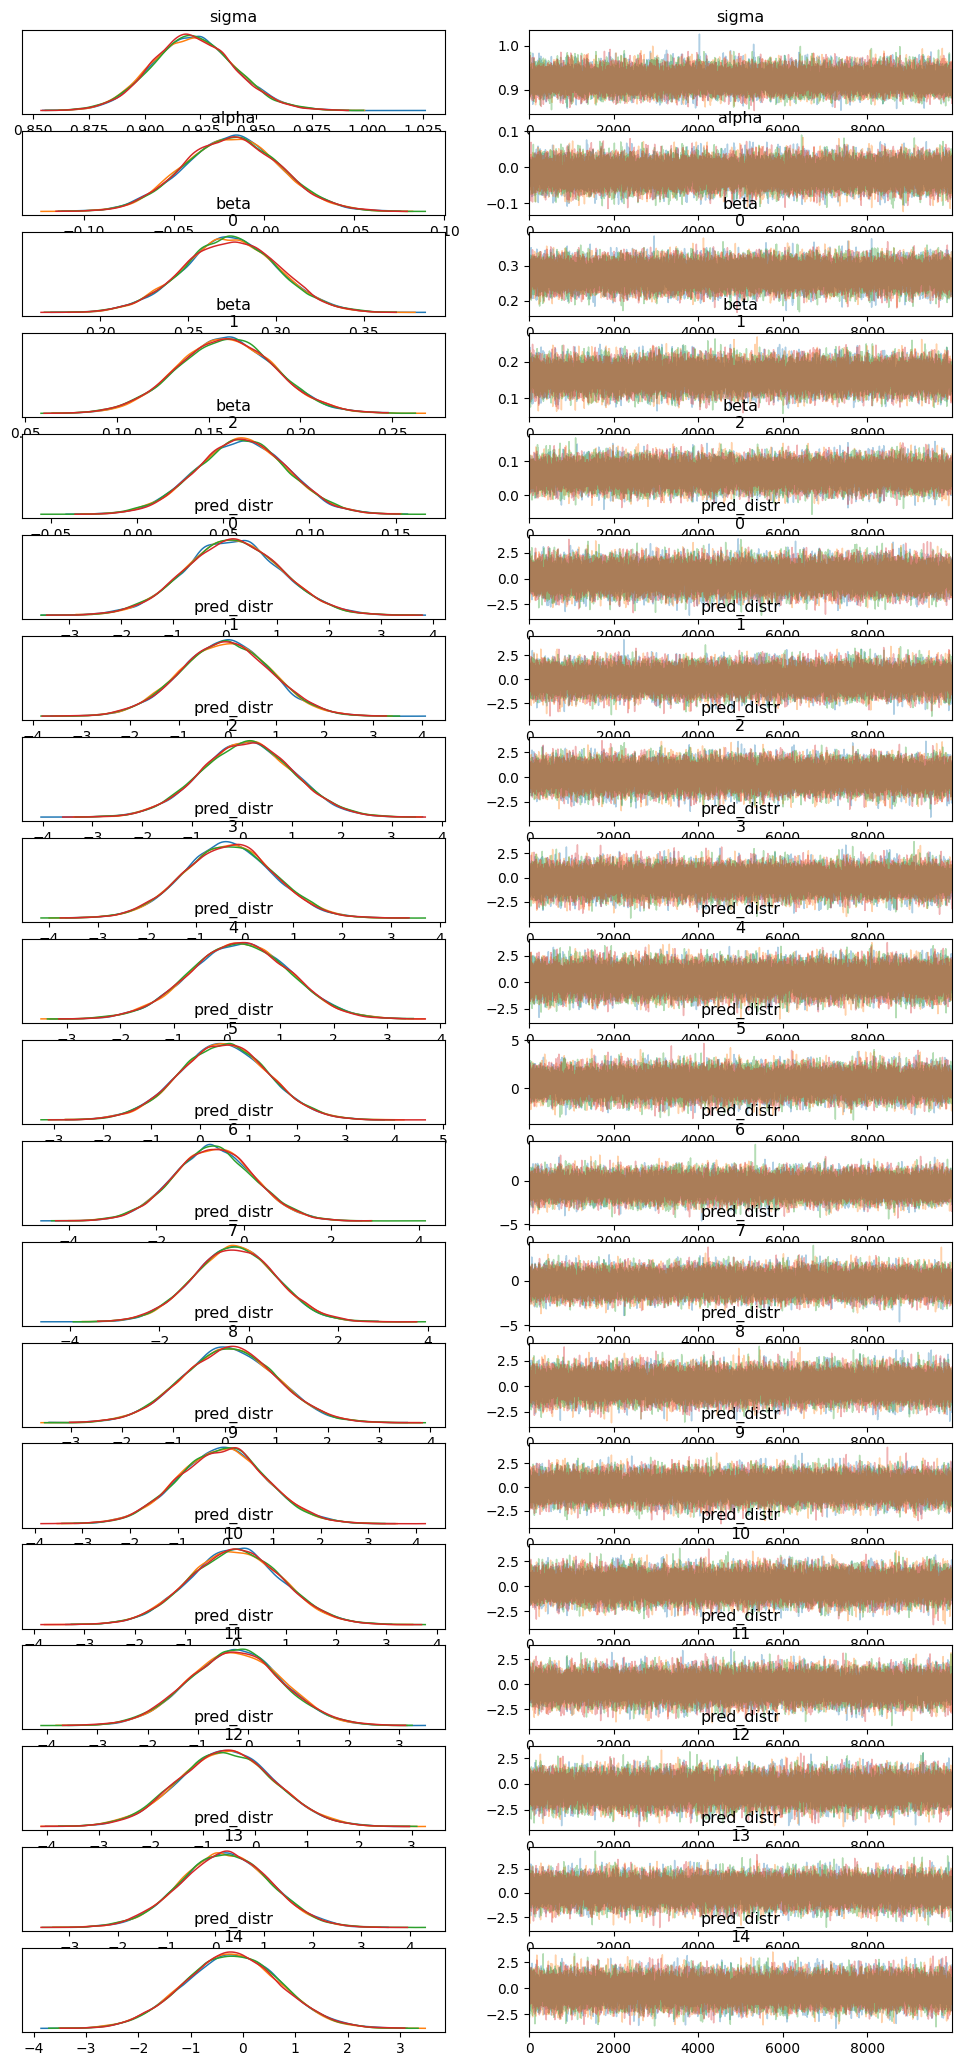

In [ ]:
az.plot_trace(fit, compact=False, figsize=(12, 26))

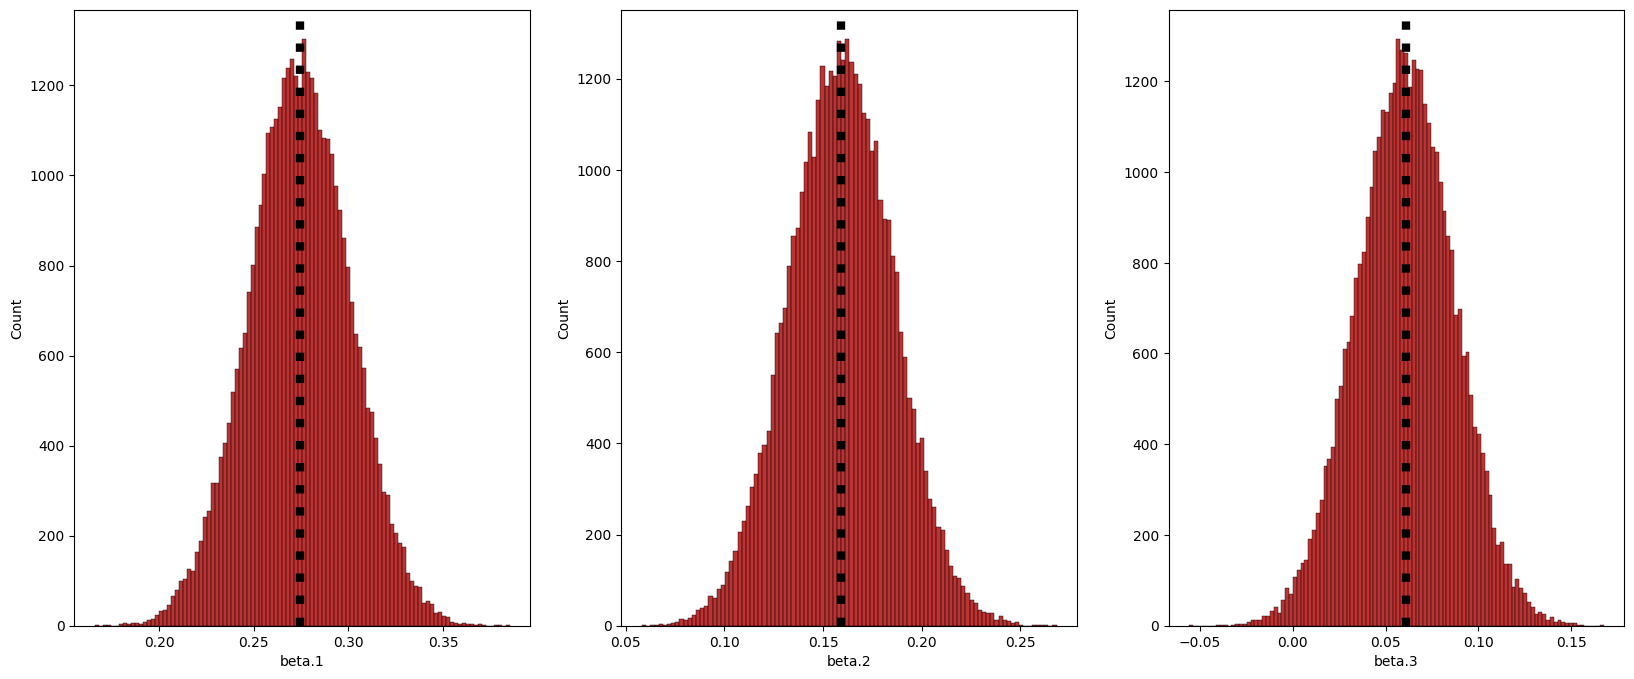

In [ ]:
results_frame = fit.to_frame()

f, ax = plt.subplots(1, 3, figsize=(20, 8))

sns.histplot(results_frame, x='beta.1', ax = ax[0], color='#AA0000', alpha=0.8, lw=2)
sns.histplot(results_frame, x='beta.2', ax = ax[1], color='#AA0000', alpha=0.8, lw=2)
sns.histplot(results_frame, x='beta.3', ax = ax[2], color='#AA0000', alpha=0.8, lw=2)

ax[0].axvline(np.mean(results_frame['beta.1']), color='black', linestyle='dotted', lw=6)
ax[1].axvline(np.mean(results_frame['beta.2']), color='black', linestyle='dotted', lw=6)
ax[2].axvline(np.mean(results_frame['beta.3']), color='black', linestyle='dotted', lw=6)

### Problem 4

In [ ]:
#Predictive distribution
pred_distr = fit['pred_distr']

In [ ]:
num_samples = testing_data_charges.shape[0] #Nunmber of samples
pred_means = np.mean(pred_distr, axis=1)

print (pred_means.shape)
print (testing_data_charges.shape)

#Calculate the RMSE
rmse = np.sqrt((1/num_samples) * np.sum((pred_means - testing_data_charges)**2))
print(f"RMSE = {rmse}")

(134,)
(134,)
RMSE = 1.232208501659163
